In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id_no_opp.csv'))

# drop opponent stat columns
summary_data.drop(columns=['allow_fg_pct','allow_ft_att_avg','allow_off_rebs_avg','allow_def_rebs_avg' ], inplace=True)
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(3101, 18)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
82,2008,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,31,-17.22,-5.72,0.323,61,71,0.388,0.622,NaN,NaN,NaN,13,6,NaN,18


In [4]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(3100, 18)


In [5]:
summary_data.rename(str.lower, axis='columns', inplace=True)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2008,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,31,-2.99,2.37,0.323,58,62,0.440,0.674,65.458065,7.0,20.0,13,5,88.606347,18
1,2008,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,36,3.37,-2.01,0.639,66,60,0.418,0.708,76.138889,11.0,21.0,13,7,86.683692,19
2,2008,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,32,5.49,3.99,0.563,73,70,0.442,0.706,83.168750,13.0,25.0,14,7,87.773352,22
3,2008,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,27,-19.72,-11.63,0.296,65,72,0.388,0.665,84.044444,12.0,22.0,16,8,77.340032,23
4,2008,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,32,-6.13,-11.20,0.688,68,63,0.466,0.634,76.018750,11.0,24.0,13,5,89.451616,19


#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


In [8]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [9]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data is available from 2010 through 2017.

So the intersection of season summary data with tournament data are seasons 2010-2017.

In [10]:
start_tournament_season = 2009

tourney_data = tourney_data[tourney_data['season'] >= start_tournament_season]
tourney_data.describe()['season']

count     597.000000
mean     2013.035176
std         2.572526
min      2009.000000
25%      2011.000000
50%      2013.000000
75%      2015.000000
max      2017.000000
Name: season, dtype: float64

In [11]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['school_t','school_o','games_t','games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
tourney_data.head()



,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.681,78.434286,11.0,22.0,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.723,77.494118,11.0,19.0,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.698,75.688235,11.0,24.0,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.724,68.341176,9.0,21.0,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.643,78.884848,12.0,21.0,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.701,81.044444,13.0,18.0,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.685,76.305556,12.0,18.0,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.748,77.496970,10.0,24.0,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.679,80.126316,11.0,27.0,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,Big 12,Atlantic 10


In [12]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=start_tournament_season]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [13]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))
temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.681,78.434286,11.0,22.0,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.723,77.494118,11.0,19.0,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.698,75.688235,11.0,24.0,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.724,68.341176,9.0,21.0,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.643,78.884848,12.0,21.0,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.701,81.044444,13.0,18.0,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.685,76.305556,12.0,18.0,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.748,77.496970,10.0,24.0,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.679,80.126316,11.0,27.0,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [14]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)

tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.681,78.434286,11.0,22.0,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.723,77.494118,11.0,19.0,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.698,75.688235,11.0,24.0,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.724,68.341176,9.0,21.0,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.643,78.884848,12.0,21.0,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.701,81.044444,13.0,18.0,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.685,76.305556,12.0,18.0,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.748,77.496970,10.0,24.0,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.679,80.126316,11.0,27.0,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [15]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,-1,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,-1,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,-1,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,-1,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,-1,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [16]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.681,78.434286,11.0,22.0,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.723,77.494118,11.0,19.0,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.698,75.688235,11.0,24.0,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.724,68.341176,9.0,21.0,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.643,78.884848,12.0,21.0,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.701,81.044444,13.0,18.0,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.685,76.305556,12.0,18.0,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.748,77.496970,10.0,24.0,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.679,80.126316,11.0,27.0,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [17]:
tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings['opp_pts_avg_t']
tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings['opp_pts_avg_o']

tourney_comp_ratings['delta_margin_victory_avg'] = tourney_comp_ratings['margin_victory_avg_t'] - \
    tourney_comp_ratings['margin_victory_avg_o']

tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings['off_rebs_avg_o']

tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings['def_rebs_avg_o']


tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings['to_net_avg_o']

tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings['off_rating_o']


tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings['ft_att_avg_o']

tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']


tourney_comp_ratings.drop(columns=['season_o'], inplace=True)


In [18]:
numeric_feature_to_scale = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.681,78.434286,11.0,22.0,12,6,98.171354,23,9.52,5.20,0.706,72,67,0.428,0.723,77.494118,11.0,19.0,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7,5,0.368381,2.186047,-0.070967,1.287496,-0.829305,6,3,1.196951,-0.090083,0.811385,0.790501,-0.124360,0.440497,0.241127,-0.419838,-0.459906,0.019520,-0.240594,-0.125357,-0.473846,-0.199537,-0.131887,-0.364947
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.698,75.688235,11.0,24.0,10,6,92.484651,19,11.98,11.45,0.559,63,62,0.439,0.724,68.341176,9.0,21.0,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8,1,1.179309,0.306581,0.720948,1.287496,-0.503383,4,6,-0.855259,1.560406,0.080321,0.790501,-0.392384,0.038279,-1.081560,-0.175420,-0.169750,-0.291450,-0.049699,-0.189623,-0.003178,-0.215145,-0.149307,0.271341
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.643,78.884848,12.0,21.0,13,7,90.004610,20,16.89,4.47,0.750,76,64,0.450,0.701,81.044444,13.0,18.0,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9,12,-0.442546,0.212607,-0.466925,1.287496,-1.155226,6,0,2.428277,0.333494,-0.519625,0.512569,0.947738,-0.792486,-0.659855,0.529078,0.563275,0.412323,0.454807,0.372706,0.496906,0.237499,0.321022,0.630983
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.685,76.305556,12.0,18.0,11,10,89.115399,20,17.42,3.80,0.818,77,62,0.482,0.748,77.496970,10.0,24.0,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9,15,-0.929103,-2.199374,0.720948,-2.441730,-1.257077,1,6,-2.086585,-0.031659,-1.473393,0.234636,0.947738,-0.778867,-0.498657,0.586588,0.517461,0.265022,0.536619,0.388773,0.555740,0.284325,0.460379,0.644815
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.679,80.126316,11.0,27.0,13,7,101.090384,22,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17,5,1.990237,2.373994,0.324990,2.530571,-0.707084,6,3,1.196951,1.669952,1.027214,0.512569,-1.330469,1.415625,0.510270,-1.066827,-0.795875,-0.831555,-0.963265,-0.928684,-1.179848,-1.089218,-0.828671,-1.042734


In [19]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,14.32,7.17,0.686,77,70,0.496,0.681,78.434286,11.0,22.0,12,6,98.171354,23,9.52,5.20,0.706,72,67,0.428,0.723,77.494118,11.0,19.0,10,7,92.910278,20,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7,5,0.368381,2.186047,-0.070967,1.287496,-0.829305,6,3,1.196951,-0.090083,0.811385,0.790501,-0.124360,0.440497,0.241127,-0.419838,-0.459906,0.019520,-0.240594,-0.125357,-0.473846,-0.199537,-0.131887,-0.364947
1,2011,12.35,4.23,0.765,70,62,0.447,0.698,75.688235,11.0,24.0,10,6,92.484651,19,11.98,11.45,0.559,63,62,0.439,0.724,68.341176,9.0,21.0,10,4,92.184541,16,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8,1,1.179309,0.306581,0.720948,1.287496,-0.503383,4,6,-0.855259,1.560406,0.080321,0.790501,-0.392384,0.038279,-1.081560,-0.175420,-0.169750,-0.291450,-0.049699,-0.189623,-0.003178,-0.215145,-0.149307,0.271341
2,2013,8.11,0.18,0.788,71,62,0.455,0.643,78.884848,12.0,21.0,13,7,90.004610,20,16.89,4.47,0.750,76,64,0.450,0.701,81.044444,13.0,18.0,11,11,93.775706,18,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9,12,-0.442546,0.212607,-0.466925,1.287496,-1.155226,6,0,2.428277,0.333494,-0.519625,0.512569,0.947738,-0.792486,-0.659855,0.529078,0.563275,0.412323,0.454807,0.372706,0.496906,0.237499,0.321022,0.630983
3,2012,8.79,0.63,0.806,68,59,0.410,0.685,76.305556,12.0,18.0,11,10,89.115399,20,17.42,3.80,0.818,77,62,0.482,0.748,77.496970,10.0,24.0,12,6,99.358724,19,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9,15,-0.929103,-2.199374,0.720948,-2.441730,-1.257077,1,6,-2.086585,-0.031659,-1.473393,0.234636,0.947738,-0.778867,-0.498657,0.586588,0.517461,0.265022,0.536619,0.388773,0.555740,0.284325,0.460379,0.644815
4,2011,24.10,7.62,0.921,81,64,0.508,0.679,80.126316,11.0,27.0,13,7,101.090384,22,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17,5,1.990237,2.373994,0.324990,2.530571,-0.707084,6,3,1.196951,1.669952,1.027214,0.512569,-1.330469,1.415625,0.510270,-1.066827,-0.795875,-0.831555,-0.963265,-0.928684,-1.179848,-1.089218,-0.828671,-1.042734


In [20]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)




feature_data.head()

,season_t,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,1,0,0.368381,2.186047,-0.070967,1.287496,-0.829305,1.196951,-0.090083,0.811385,0.790501,-0.124360,0.440497,0.241127,-0.419838,-0.459906,0.019520,-0.240594,-0.125357,-0.473846,-0.199537,-0.131887,-0.364947
1,2011,-1,0,1.179309,0.306581,0.720948,1.287496,-0.503383,-0.855259,1.560406,0.080321,0.790501,-0.392384,0.038279,-1.081560,-0.175420,-0.169750,-0.291450,-0.049699,-0.189623,-0.003178,-0.215145,-0.149307,0.271341
2,2013,0,1,-0.442546,0.212607,-0.466925,1.287496,-1.155226,2.428277,0.333494,-0.519625,0.512569,0.947738,-0.792486,-0.659855,0.529078,0.563275,0.412323,0.454807,0.372706,0.496906,0.237499,0.321022,0.630983
3,2012,0,1,-0.929103,-2.199374,0.720948,-2.441730,-1.257077,-2.086585,-0.031659,-1.473393,0.234636,0.947738,-0.778867,-0.498657,0.586588,0.517461,0.265022,0.536619,0.388773,0.555740,0.284325,0.460379,0.644815
4,2011,1,1,1.990237,2.373994,0.324990,2.530571,-0.707084,1.196951,1.669952,1.027214,0.512569,-1.330469,1.415625,0.510270,-1.066827,-0.795875,-0.831555,-0.963265,-0.928684,-1.179848,-1.089218,-0.828671,-1.042734


In [21]:
X= feature_data[feature_data['season_t']>=start_tournament_season]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=start_tournament_season]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf',
 'upset_seed_threshold',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(477, 23)
(477,)
(120, 23)
(120,)


,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
399,1,0,0.044010,-0.319908,1.116906,-1.613013,-0.849675,0.376067,0.355403,-0.422591,1.346366,-0.526396,0.336084,0.582233,-0.161043,-0.123936,-0.209616,-0.267864,-0.237823,-0.179679,-0.324405,-0.218985,-0.185127
424,-1,1,-2.388773,-1.604210,-1.258840,0.044420,-1.012636,2.428277,-2.383241,-1.743824,-0.599161,2.019835,-2.878025,-2.263198,3.476471,3.403746,3.554752,3.359130,3.521750,3.306206,3.421621,3.665586,3.245301
490,1,1,-0.929103,-0.664477,-1.258840,-2.441730,1.044743,-1.265701,-1.149025,0.081353,-1.988823,1.081750,-0.178718,0.501634,0.112130,0.257848,0.363223,0.100289,0.388773,0.099780,0.409192,0.495218,0.008526
390,1,0,-0.929103,-1.071695,1.116906,0.458779,-1.297817,-0.034375,-1.463056,-0.908374,0.234636,0.679713,-0.637228,-0.186336,0.212773,0.257848,0.575991,0.345725,0.469106,0.232156,0.315542,0.442960,0.285174
218,-1,1,-1.091289,0.149959,0.324990,-0.784296,1.513255,0.786509,-1.375420,0.334917,0.234636,1.751811,-1.461638,-1.386684,1.348597,1.281028,1.607101,1.559268,1.786562,1.349992,1.720301,1.522975,1.225775


In [23]:
# mark the records used for training
#tourney_comp_ratings['train_rec'] = 0
#tourney_comp_ratings.loc[X_train.index,'train_rec']= 1
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.681,78.434286,11.0,22.0,12,6,98.171354,23,9.52,5.20,0.706,72,67,0.428,0.723,77.494118,11.0,19.0,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7,5,0.368381,2.186047,-0.070967,1.287496,-0.829305,6,3,1.196951,-0.090083,0.811385,0.790501,-0.124360,0.440497,0.241127,-0.419838,-0.459906,0.019520,-0.240594,-0.125357,-0.473846,-0.199537,-0.131887,-0.364947
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.698,75.688235,11.0,24.0,10,6,92.484651,19,11.98,11.45,0.559,63,62,0.439,0.724,68.341176,9.0,21.0,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8,1,1.179309,0.306581,0.720948,1.287496,-0.503383,4,6,-0.855259,1.560406,0.080321,0.790501,-0.392384,0.038279,-1.081560,-0.175420,-0.169750,-0.291450,-0.049699,-0.189623,-0.003178,-0.215145,-0.149307,0.271341
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.643,78.884848,12.0,21.0,13,7,90.004610,20,16.89,4.47,0.750,76,64,0.450,0.701,81.044444,13.0,18.0,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9,12,-0.442546,0.212607,-0.466925,1.287496,-1.155226,6,0,2.428277,0.333494,-0.519625,0.512569,0.947738,-0.792486,-0.659855,0.529078,0.563275,0.412323,0.454807,0.372706,0.496906,0.237499,0.321022,0.630983
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.685,76.305556,12.0,18.0,11,10,89.115399,20,17.42,3.80,0.818,77,62,0.482,0.748,77.496970,10.0,24.0,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9,15,-0.929103,-2.199374,0.720948,-2.441730,-1.257077,1,6,-2.086585,-0.031659,-1.473393,0.234636,0.947738,-0.778867,-0.498657,0.586588,0.517461,0.265022,0.536619,0.388773,0.555740,0.284325,0.460379,0.644815
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.679,80.126316,11.0,27.0,13,7,101.090384,22,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17,5,1.990237,2.373994,0.324990,2.530571,-0.707084,6,3,1.196951,1.669952,1.027214,0.512569,-1.330469,1.415625,0.510270,-1.066827,-0.795875,-0.831555,-0.963265,-0.928684,-1.179848,-1.089218,-0.828671,-1.042734


#### Baseline Model

In [24]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-3.12098816e-01 -1.62612916e-01 -6.26222451e-01 -2.00561753e-01
   1.70507969e-01 -1.81642219e-01  2.71919012e-02  4.85682373e-02
   3.24676850e+00  1.06438674e-01 -1.28302968e-01  1.15732770e+00
   2.06479766e+00  3.00458889e+00 -1.48287349e-01 -6.50809697e-01
   1.27166671e-04  1.07139026e+00  1.05605661e+00  4.88874254e-01
   1.67166953e+00  2.74432216e-01 -5.22655862e-01]]
Intercept  [0.00104816]


In [25]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.246768497625929
delta_sos   3.004588891828736
delta_srs   2.0647976553789147
delta_dol   1.6716695252031117
delta_seed   1.157327697587417
delta_rth   1.0713902600705978
delta_col   1.0560566123134119
delta_wlk   -0.6508096971795014
delta_margin_victory_avg   -0.6262224505492593
delta_mor   -0.5226558621740126
delta_pom   0.4888742537013675
top_conf   -0.31209881637705134
delta_rpi   0.2744322163918261
delta_fg_pct   -0.20056175262819292
delta_def_rebs_avg   -0.18164221852569534
delta_off_rebs_avg   0.1705079692757338
upset_seed_threshold   -0.16261291563855484
delta_sag   -0.1482873491461887
delta_ft_att_avg   -0.12830296849822187
delta_off_rating   0.10643867420068341
delta_to_net_avg   0.048568237250788335
delta_ft_pct   0.02719190122326509
delta_wol   0.00012716667080771944


[('delta_win_pct', 3.246768497625929),
 ('delta_sos', 3.004588891828736),
 ('delta_srs', 2.0647976553789147),
 ('delta_dol', 1.6716695252031117),
 ('delta_seed', 1.157327697587417),
 ('delta_rth', 1.0713902600705978),
 ('delta_col', 1.0560566123134119),
 ('delta_wlk', -0.6508096971795014),
 ('delta_margin_victory_avg', -0.6262224505492593),
 ('delta_mor', -0.5226558621740126),
 ('delta_pom', 0.4888742537013675),
 ('top_conf', -0.31209881637705134),
 ('delta_rpi', 0.2744322163918261),
 ('delta_fg_pct', -0.20056175262819292),
 ('delta_def_rebs_avg', -0.18164221852569534),
 ('delta_off_rebs_avg', 0.1705079692757338),
 ('upset_seed_threshold', -0.16261291563855484),
 ('delta_sag', -0.1482873491461887),
 ('delta_ft_att_avg', -0.12830296849822187),
 ('delta_off_rating', 0.10643867420068341),
 ('delta_to_net_avg', 0.048568237250788335),
 ('delta_ft_pct', 0.02719190122326509),
 ('delta_wol', 0.00012716667080771944)]

In [26]:
y_pred = logreg.predict(X_test)


array([[52,  9],
       [14, 45]], dtype=int64)

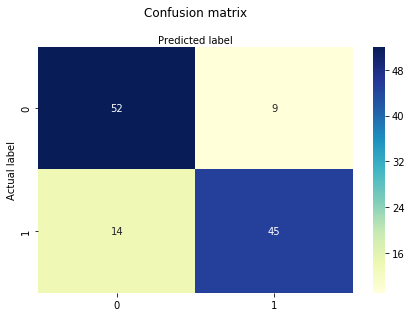

In [27]:
utils.display_confusion_matrix(y_test, y_pred)

In [28]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.8083333333333333
Precision: 0.8333333333333334
Recall: 0.7627118644067796
Log loss=  0.3690569233126653


In [29]:
scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.8206925774400936


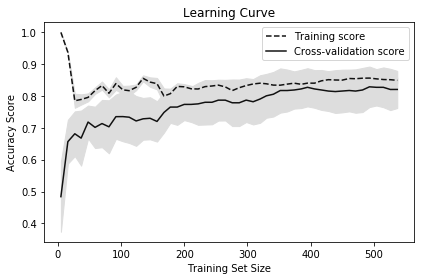

In [30]:
train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Model Feature Optimization

In [31]:
X = feature_data[feature_data['season_t']>=start_tournament_season]
X = X.drop(columns=['season_t'])
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=start_tournament_season]['game_result']

model_stats = eliminate_features_logistic_regression(logreg, X,y)

Iteration=  0
least_important label=  delta_wol
Iteration=  1
least_important label=  delta_ft_pct
Iteration=  2
least_important label=  delta_to_net_avg
Iteration=  3
least_important label=  delta_off_rating
Iteration=  4
least_important label=  delta_ft_att_avg
Iteration=  5
least_important label=  delta_sag
Iteration=  6
least_important label=  upset_seed_threshold
Iteration=  7
least_important label=  delta_off_rebs_avg
Iteration=  8
least_important label=  delta_def_rebs_avg
Iteration=  9
least_important label=  delta_fg_pct
Iteration=  10
least_important label=  delta_rpi
Iteration=  11
least_important label=  top_conf
Iteration=  12
least_important label=  delta_pom
Iteration=  13
least_important label=  delta_mor
Iteration=  14
least_important label=  delta_margin_victory_avg
Iteration=  15
least_important label=  delta_wlk
Iteration=  16
least_important label=  delta_col
Iteration=  17
least_important label=  delta_rth
Iteration=  18
least_important label=  delta_seed
Iteratio

In [32]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.8083 Cross Val= 0.8207  Log Loss= 0.3691
Accuracy= 0.8083 Cross Val= 0.8207  Log Loss= 0.3691
Accuracy= 0.8167 Cross Val= 0.8224  Log Loss= 0.3687
Accuracy= 0.8333 Cross Val= 0.8223  Log Loss= 0.3670
Accuracy= 0.8333 Cross Val= 0.8223  Log Loss= 0.3651
Accuracy= 0.8333 Cross Val= 0.8308  Log Loss= 0.3671
Accuracy= 0.8333 Cross Val= 0.8307  Log Loss= 0.3666
Accuracy= 0.8333 Cross Val= 0.8308  Log Loss= 0.3685
Accuracy= 0.8250 Cross Val= 0.8324  Log Loss= 0.3657
Accuracy= 0.8333 Cross Val= 0.8324  Log Loss= 0.3670
Accuracy= 0.8333 Cross Val= 0.8425  Log Loss= 0.3651
Accuracy= 0.8333 Cross Val= 0.8476  Log Loss= 0.3653
Accuracy= 0.8583 Cross Val= 0.8392  Log Loss= 0.3625
Accuracy= 0.8583 Cross Val= 0.8375  Log Loss= 0.3640
Accuracy= 0.8500 Cross Val= 0.8375  Log Loss= 0.3637
Accuracy= 0.8333 Cross Val= 0.8358  Log Loss= 0.3720
Accuracy= 0.8333 Cross Val= 0.8341  Log Loss= 0.3709
Accuracy= 0.8333 Cross Val= 0.8274  Log Loss= 0.3807
Accuracy= 0.8083 Cross Val= 0.8274  Log Loss= 

In [33]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['top_conf', 'delta_margin_victory_avg', 'delta_win_pct', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_wlk', 'delta_rth', 'delta_col', 'delta_pom', 'delta_dol', 'delta_mor']


In [34]:
X = feature_data[feature_data['season_t']>=start_tournament_season][model_features]

array([[54,  7],
       [13, 46]], dtype=int64)

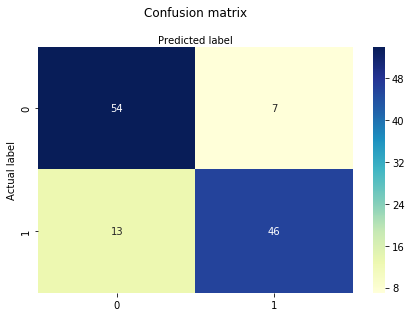

In [35]:
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=start_tournament_season]['game_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
# save model stats
prediction_probabilities = logreg.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
log_loss_value = log_loss(y_test, prediction_probabilities)
cross_val_scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
utils.display_confusion_matrix(y_test, y_pred)



In [36]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.210907144006372
delta_sos   3.0370382645879497
delta_srs   2.0471292792354623
delta_dol   1.677339574369989
delta_seed   1.2454955589316161
delta_col   1.2417442907310323
delta_rth   1.027818288109083
delta_margin_victory_avg   -0.7162890300119856
delta_wlk   -0.6352861514469257
delta_mor   -0.4822436393142884
delta_pom   0.3641239739441939
top_conf   -0.2750468199881355


[('delta_win_pct', 3.210907144006372),
 ('delta_sos', 3.0370382645879497),
 ('delta_srs', 2.0471292792354623),
 ('delta_dol', 1.677339574369989),
 ('delta_seed', 1.2454955589316161),
 ('delta_col', 1.2417442907310323),
 ('delta_rth', 1.027818288109083),
 ('delta_margin_victory_avg', -0.7162890300119856),
 ('delta_wlk', -0.6352861514469257),
 ('delta_mor', -0.4822436393142884),
 ('delta_pom', 0.3641239739441939),
 ('top_conf', -0.2750468199881355)]

In [37]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.8333333333333334
Precision: 0.8679245283018868
Recall: 0.7796610169491526
Log loss=  0.3653304836642507


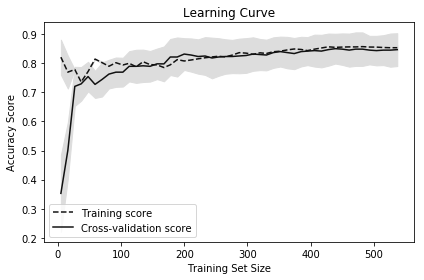

In [38]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [39]:
# Retrieve the non-normalized game stats
prediction_probabilities = logreg.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
7,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2010,Win,8.56,3.78,0.700,71,66,0.434,0.715,75.240000,10.0,21.0,11,8,94.364700,20,14.61,10.39,0.656,70,66,0.475,0.734,73.850000,10.0,23.0,13,6,94.786730,17,Atlantic 10,Big East,77,55.0,54,74,59.0,84.0,72.0,49.0,80,16,19.0,16,17,16.0,31.0,19.0,13.0,42,0,0,5,4,1.0,-0.041,-2.775558e-17,-2.0,-0.019,3,7,-4.0,0.044,-0.422030,3.0,5.0,-6.05,-6.61,61.0,36.0,38.0,57.0,43.0,53.0,53.0,36.0,38.0,1,0.612733
12,2015,64,2015-03-19,12,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,5,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,-1,2014,Lose,8.61,-4.20,0.853,78,64,0.487,0.736,78.400000,12.0,22.0,14,7,99.489796,23,20.98,7.42,0.743,71,57,0.482,0.703,70.600000,9.0,25.0,11,5,100.566572,21,Southland,Pacific 12,41,53.0,24,47,42.0,35.0,39.0,33.0,70,12,10.0,20,17,23.0,8.0,20.0,19.0,10,-1,1,14,14,0.0,0.005,3.000000e+00,-3.0,0.033,7,6,1.0,0.110,-1.076776,2.0,7.0,-12.37,-11.62,29.0,43.0,4.0,30.0,19.0,27.0,19.0,14.0,60.0,-1,0.060977
28,2012,64,2012-03-16,5,Temple,8598d1b6-106b-4083-a512-2e495729525a,12,South Florida,55af9c69-3675-4b9b-a882-96640b782fff,-1,2011,Lose,10.44,4.94,0.750,75,69,0.469,0.719,77.743750,10.0,21.0,12,7,96.470777,19,9.20,7.29,0.611,59,56,0.437,0.705,69.133333,10.0,20.0,13,5,85.342334,16,American Athletic,American Athletic,36,29.0,28,35,22.0,34.0,20.0,20.0,42,70,51.0,60,53,59.0,66.0,60.0,52.0,47,0,1,6,3,3.0,0.032,-2.775558e-17,1.0,0.014,5,8,-3.0,0.139,11.128444,3.0,-7.0,1.24,-2.35,-34.0,-22.0,-32.0,-18.0,-37.0,-32.0,-40.0,-32.0,-5.0,-1,0.265154
34,2017,32,2017-03-19,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,3,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,-1,2016,Lose,12.88,4.62,0.714,73,65,0.454,0.668,77.840000,11.0,25.0,11,6,93.782117,22,20.80,8.38,0.846,78,65,0.481,0.712,77.917949,10.0,26.0,11,6,100.105305,20,Atlantic 10,Pacific 12,48,40.0,48,53,43.0,37.0,52.0,31.0,31,13,14.0,8,11,7.0,16.0,12.0,9.0,24,-1,1,8,13,-5.0,-0.027,1.000000e+00,-1.0,-0.044,5,5,0.0,-0.132,-6.323188,2.0,8.0,-7.92,-3.76,35.0,26.0,40.0,42.0,36.0,21.0,40.0,22.0,7.0,-1,0.135278
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,-1,2012,Lose,-3.21,-5.80,0.588,78,76,0.479,0.691,80.676471,11.0,19.0,14,6,96.682464,25,-1.73,-2.28,0.583,65,64,0.421,0.699,72.988889,10.0,19.0,11,7,89.054651,19,Northeast,Colonial,163,182.0,171,182,173.0,185.0,193.0,179.0,134,169,183.0,183,184,179.0,179.0,168.0,182.0,155,0,0,2,1,1.0,0.058,1.000000e+00,0.0,-0.008,8,4,4.0,0.005,7.627814,6.0,0.0,-1.48,-3.52,-6.0,-1.0,-12.0,-2.0,-6.0,6.0,25.0,-3.0,-21.0,-1,0.244739


In [40]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])

missed_predictions

Missed predictions=  20


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
140,2014,8,2014-03-29,1,Arizona,9b166a3f-e64b-4825-bb6b-92c6f0418263,2,Wisconsin,c7569eae-5b93-4197-b204-6f3a62146b25,-1,2013,Lose,23.36,9.04,0.868,72,58,0.469,0.659,75.210526,12.0,25.0,10,5,95.731281,22,19.69,10.19,0.789,73,64,0.459,0.746,70.273684,8.0,24.0,8,4,103.879569,22,Pacific 12,Big Ten,1,1.0,3,3,2.0,1.0,3.0,2.0,4,9,9.0,13,13,7.0,13.0,7.0,6.0,9,0,0,14,9,5.0,0.010,4.000000e+00,1.0,-0.087,5,4,1.0,0.079,-8.148288,0.0,-1.0,3.67,-1.15,-8.0,-8.0,-10.0,-10.0,-5.0,-12.0,-4.0,-4.0,-5.0,1,0.727768
450,2011,32,2011-03-20,2,Notre Dame,80962f09-8821-48b6-8cf0-0cf0eea56aa8,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,-1,2010,Lose,18.17,8.43,0.794,75,65,0.460,0.724,74.317647,10.0,26.0,10,4,100.918157,24,13.48,6.45,0.676,69,62,0.435,0.665,80.411765,12.0,26.0,15,8,85.808339,21,Atlantic Coast,Atlantic Coast,8,6.0,6,6,7.0,10.0,5.0,9.0,7,44,39.0,49,42,45.0,42.0,42.0,55.0,37,0,1,10,7,3.0,0.025,-2.000000e+00,0.0,0.059,6,7,-1.0,0.118,15.109818,3.0,-8.0,4.69,1.98,-36.0,-33.0,-43.0,-36.0,-38.0,-32.0,-37.0,-46.0,-30.0,1,0.718097
116,2010,64,2010-03-18,4,Vanderbilt,72971b77-1d35-40b3-bb63-4c5b29f3d22b,13,Murray State,77a69fb0-1355-4342-ac09-b4cc7949d95e,-1,2009,Lose,15.24,7.86,0.727,76,68,0.470,0.721,79.351515,10.0,25.0,13,5,95.776369,25,8.69,-3.89,0.861,76,60,0.499,0.695,78.233333,12.0,24.0,14,9,97.145292,22,Southeastern,Ohio Valley,27,27.0,24,24,19.0,36.0,24.0,26.0,29,61,46.0,44,71,59.0,57.0,48.0,57.0,75,1,1,8,16,-8.0,-0.029,-2.000000e+00,1.0,0.026,8,5,3.0,-0.134,-1.368923,3.0,-9.0,6.55,11.75,-34.0,-19.0,-20.0,-47.0,-40.0,-21.0,-24.0,-31.0,-46.0,1,0.657936
442,2017,16,2017-03-24,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,7,South Carolina,1c7ec608-3b36-4cee-adac-9265e3792597,-1,2016,Lose,19.75,11.87,0.771,72,63,0.471,0.723,76.840000,12.0,25.0,13,5,93.701197,18,17.52,10.16,0.703,73,65,0.421,0.699,81.800000,12.0,23.0,12,7,89.242054,23,Big 12,Southeastern,14,12.0,12,10,11.0,13.0,8.0,11.0,20,31,33.0,42,37,37.0,31.0,37.0,43.0,49,0,0,9,8,1.0,0.050,-2.775558e-17,2.0,0.024,8,5,3.0,0.068,4.459143,-5.0,-4.0,2.23,1.71,-17.0,-21.0,-30.0,-27.0,-26.0,-18.0,-29.0,-32.0,-29.0,1,0.648894
50,2013,68,2013-03-19,16,Liberty,559db90c-741f-40d1-aa81-3fdd1d4889f3,16,North Carolina A&T,53aaac6a-796e-41a6-a04e-6ce74c5717f8,-1,2012,Lose,-9.13,-5.80,0.417,69,69,0.429,0.730,76.111111,10.0,22.0,13,5,90.656934,21,-6.94,-6.30,0.541,62,61,0.403,0.658,76.070270,10.0,21.0,15,7,81.503588,21,Big South,Mid Eastern Athletic,260,264.0,299,296,293.0,251.0,278.0,287.0,237,242,223.0,219,246,222.0,226.0,221.0,213.0,234,0,0,0,1,-1.0,0.026,-2.775558e-17,1.0,0.072,8,8,0.0,-0.124,9.153346,0.0,0.0,-2.19,0.50,18.0,41.0,80.0,50.0,71.0,25.0,57.0,74.0,3.0,1,0.584832
120,2009,64,2009-03-19,9,Butler,bdb7d7a4-45f8-4bf3-ab85-15488c451494,8,LSU,70e2bedd-3a0a-479c-ac99-e3f58aa6824b,-1,2008,Lose,10.07,2.07,0.813,67,57,0.438,0.724,71.431250,10.0,23.0,12,6,93.796483,21,11.87,3.27,0.771,74,66,0.448,0.716,80.400000,13.0,25.0,12,7,92.039801,21,Big East,Southeastern,33,26.0,20,38,21.0,43.0,30.0,24.0,57,40,36.0,33,36,30.0,46.0,23.0,37.0,37,-1,0,10,8,2.0,-0.010,-3.00

In [41]:
feature_dictionary = utils.Feature_Dictionary()


In [42]:
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)

                                      Arizona                  Wisconsin     Stat Supports Winner
Turnover Avg                    10.00                               8.00         True  (L)
Net Turnover Avg                 5.00                               4.00         True  (L)
SOS                              9.04                              10.19         True  (H)
PPG                             72.00                              73.00         True  (H)
FT ATT Avg                      22.00                              22.00         True  (H)
FT %                            65.90                              74.60         True  (H)
Off Rating                      95.73                             103.88         True  (H)
Seed                              1                                  2          False  (L)
SAG                              1.00                               9.00        False  (L)
WLK                              1.00                               9.00        Fal

140    [(Turnover Avg                    10.00       ...
450    [(Allow PPG                       65.00       ...
116    [(Allow PPG                       68.00       ...
442    [(Turnover Avg                    13.00       ...
50     [(Seed                             16         ...
120    [(Seed                              9         ...
72     [(PPG                             64.00       ...
53     [(SOS                              6.13       ...
305    [(Seed                              8         ...
575    [(Allow PPG                       69.00       ...
513    [(Allow PPG                       63.00       ...
107    [(Seed                             10         ...
521    [(Turnover Avg                     9.00       ...
577    [(SOS                              8.58       ...
123    [(Seed                              6         ...
129    [(Turnover Avg                    11.00       ...
333    [(Seed                              5         ...
151    [(Allow PPG             

In [43]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)

In [44]:
missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
    len(model_features)

missed_predictions['game_index'] = missed_predictions.index
missed_predictions.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
140,2014,8,2014-03-29,1,Arizona,9b166a3f-e64b-4825-bb6b-92c6f0418263,2,Wisconsin,c7569eae-5b93-4197-b204-6f3a62146b25,-1,2013,Lose,23.36,9.04,0.868,72,58,0.469,0.659,75.210526,12.0,25.0,10,5,95.731281,22,19.69,10.19,0.789,73,64,0.459,0.746,70.273684,8.0,24.0,8,4,103.879569,22,Pacific 12,Big Ten,1,1.0,3,3,2.0,1.0,3.0,2.0,4,9,9.0,13,13,7.0,13.0,7.0,6.0,9,0,0,14,9,5.0,0.010,4.000000e+00,1.0,-0.087,5,4,1.0,0.079,-8.148288,0.0,-1.0,3.67,-1.15,-8.0,-8.0,-10.0,-10.0,-5.0,-12.0,-4.0,-4.0,-5.0,1,0.727768,"[ft_pct, to_net_avg, off_rating, ft_att_avg, sos]",[sos],21.739130,8.333333,140
450,2011,32,2011-03-20,2,Notre Dame,80962f09-8821-48b6-8cf0-0cf0eea56aa8,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,-1,2010,Lose,18.17,8.43,0.794,75,65,0.460,0.724,74.317647,10.0,26.0,10,4,100.918157,24,13.48,6.45,0.676,69,62,0.435,0.665,80.411765,12.0,26.0,15,8,85.808339,21,Atlantic Coast,Atlantic Coast,8,6.0,6,6,7.0,10.0,5.0,9.0,7,44,39.0,49,42,45.0,42.0,42.0,55.0,37,0,1,10,7,3.0,0.025,-2.000000e+00,0.0,0.059,6,7,-1.0,0.118,15.109818,3.0,-8.0,4.69,1.98,-36.0,-33.0,-43.0,-36.0,-38.0,-32.0,-37.0,-46.0,-30.0,1,0.718097,"[off_rebs_avg, def_rebs_avg]",[],8.695652,0.000000,450
116,2010,64,2010-03-18,4,Vanderbilt,72971b77-1d35-40b3-bb63-4c5b29f3d22b,13,Murray State,77a69fb0-1355-4342-ac09-b4cc7949d95e,-1,2009,Lose,15.24,7.86,0.727,76,68,0.470,0.721,79.351515,10.0,25.0,13,5,95.776369,25,8.69,-3.89,0.861,76,60,0.499,0.695,78.233333,12.0,24.0,14,9,97.145292,22,Southeastern,Ohio Valley,27,27.0,24,24,19.0,36.0,24.0,26.0,29,61,46.0,44,71,59.0,57.0,48.0,57.0,75,1,1,8,16,-8.0,-0.029,-2.000000e+00,1.0,0.026,8,5,3.0,-0.134,-1.368923,3.0,-9.0,6.55,11.75,-34.0,-19.0,-20.0,-47.0,-40.0,-21.0,-24.0,-31.0,-46.0,1,0.657936,"[margin_victory_avg, fg_pct, off_rebs_avg, to_...","[margin_victory_avg, win_pct]",26.086957,16.666667,116
442,2017,16,2017-03-24,3,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,7,South Carolina,1c7ec608-3b36-4cee-adac-9265e3792597,-1,2016,Lose,19.75,11.87,0.771,72,63,0.471,0.723,76.840000,12.0,25.0,13,5,93.701197,18,17.52,10.16,0.703,73,65,0.421,0.699,81.800000,12.0,23.0,12,7,89.242054,23,Big 12,Southeastern,14,12.0,12,10,11.0,13.0,8.0,11.0,20,31,33.0,42,37,37.0,31.0,37.0,43.0,49,0,0,9,8,1.0,0.050,-2.775558e-17,2.0,0.024,8,5,3.0,0.068,4.459143,-5.0,-4.0,2.23,1.71,-17.0,-21.0,-30.0,-27.0,-26.0,-18.0,-29.0,-32.0,-29.0,1,0.648894,"[off_rebs_avg, to_net_avg, ft_att_avg]",[],13.043478,0.000000,442
50,2013,68,2013-03-19,16,Liberty,559db90c-741f-40d1-aa81-3fdd1d4889f3,16,North Carolina A&T,53aaac6a-796e-41a6-a04e-6ce74c5717f8,-1,2012,Lose,-9.13,-5.80,0.417,69,69,0.429,0.730,76.111111,10.0,22.0,13,5,90.656934,21,-6.94,-6.30,0.541,62,61,0.403,0.658,76.070270,10.0,21.0,15,7,81.503588,21,Big South,Mid Eastern Athletic,260,264.0,299,296,293.0,251.0,278.0,287.0,237,242,223.0,219,246,222.0,226.0,221.0,213.0,234,0,0,0,1,-1.0,0.026,-2.775558e-17,1.0,0.072,8,8,0.0,-0.124,9.153346,0.0,0.0,-2.19,0.50,18.0,41.0,80.0,50.0,71.0,25.0,57.0,74.0,3.0,1,0.584832,

In [45]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
plot_missed_predictions_df.head()

,game_index,Features Supporting Outcome,value
0,140,features,21.739130
1,450,features,8.695652
2,116,features,26.086957
3,442,features,13.043478
4,50,features,69.565217


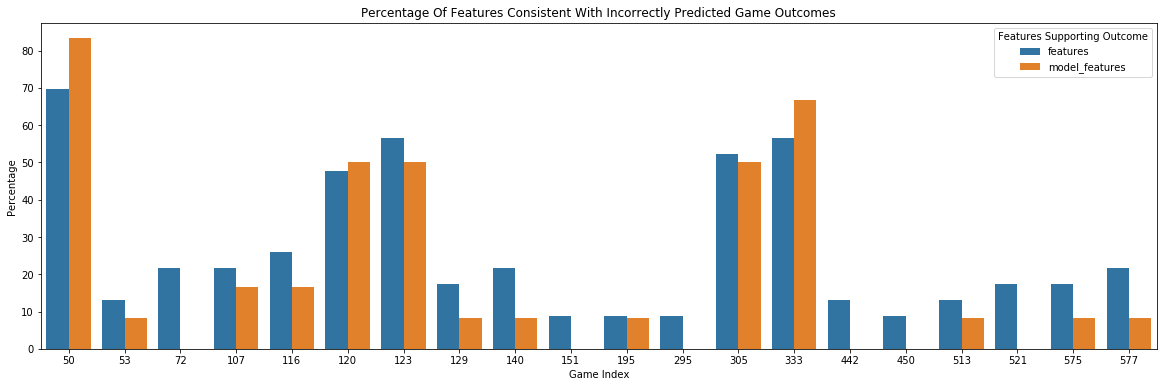

In [46]:
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

##### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.